# Identify Maximally Representative Partition (Yeh HCP842, LC, BNA)

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import bct
from nilearn import surface, plotting, image, regions

/home/despoB/dlurie/anaconda3/envs/timescale/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context('notebook')

In [3]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
def load_partitions(data_dir):
    gamma_range = np.arange(5,36,1) / 10
    partition_store = []
    matrix_store = []
    q_store = []
    vi_store = []
    mi_store = []
    pc_store = []
    wd_store = []
    for y in gamma_range:
        part_data = np.genfromtxt(f'{data_dir}/gamma_{y}_GraphPartition.txt')
        mat_data = np.genfromtxt(f'{data_dir}/gamma_{y}_ReorderedMatrix.txt')
        q_data = np.genfromtxt(f'{data_dir}/gamma_{y}_ModularityQ.txt')
        vi_data = np.genfromtxt(f'{data_dir}/gamma_{y}_meanVI.txt')
        mi_data = np.genfromtxt(f'{data_dir}/gamma_{y}_meanMI.txt')
        pc_data = np.genfromtxt(f'{data_dir}/gamma_{y}_PC.txt')
        wd_data = np.genfromtxt(f'{data_dir}/gamma_{y}_WMDz.txt')
        
        partition_store.append(part_data)
        matrix_store.append(mat_data)
        q_store.append(q_data)
        vi_store.append(float(vi_data))
        mi_store.append(float(mi_data))
        pc_store.append(pc_data)
        wd_store.append(wd_data)
    
    return np.array(partition_store), np.array(matrix_store), \
           np.array(q_store), np.array(vi_store), np.array(mi_store), np.array(pc_store), np.array(wd_store)

In [5]:
def gen_surfaces(measure, idx_lh, idx_rh):
    measure_lh = measure[:210][::2] # Select even numbered ROIs
    measure_rh = measure[:210][1::2] # Select odd numbered ROIs

    measure_lh = np.insert(measure_lh, 0, [0,0], axis=0)
    measure_rh = np.insert(measure_rh, 0, [0,0], axis=0)

    measure_map_lh = measure_lh[idx_lh]
    measure_map_rh = measure_rh[idx_rh]
    
    return measure_map_lh, measure_map_rh

In [6]:
def plot_surfaces(lh_surf, map_lh, lh_bg, rh_surf, map_rh, rh_bg, plot_cmap, plot_vmin, plot_vmax):
    fig, ax = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(20,20))
    a = plotting.plot_surf_roi(lh_infl, map_lh, hemi='left', cmap=plot_cmap, view='lateral',
                             bg_map=lh_sulc, bg_on_data=True, darkness=0.6, vmin=plot_vmin, vmax=plot_vmax, threshold=1e-15, figure=fig, axes=ax[0][0])
    b = plotting.plot_surf_roi(rh_infl, map_rh, hemi='right', cmap=plot_cmap, view='lateral',
                             bg_map=rh_sulc, bg_on_data=True, darkness=0.6, vmin=plot_vmin, vmax=plot_vmax, threshold=1e-15, figure=fig, axes=ax[0][1])
    c = plotting.plot_surf_roi(lh_infl, map_lh, hemi='left', cmap=plot_cmap, view='medial',
                             bg_map=lh_sulc, bg_on_data=True, darkness=0.6, vmin=plot_vmin, vmax=plot_vmax, threshold=1e-15, figure=fig, axes=ax[1][0])
    d = plotting.plot_surf_roi(rh_infl, map_rh, hemi='right', cmap=plot_cmap, view='medial',
                             bg_map=rh_sulc, bg_on_data=True, darkness=0.6, vmin=plot_vmin, vmax=plot_vmax, threshold=1e-15, figure=fig, axes=ax[1][1])
    plt.tight_layout()

In [7]:
def plot_colorbar(data, cmap):
    plt.figure(figsize=(6, 1))
    img = plt.imshow([data], cmap=cmap)
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    plt.colorbar(orientation="horizontal", cax=cax)

In [8]:
part_data, mat_data, q_data, vi_data, mi_data, pc_data, wd_data = load_partitions('/home/despo/dlurie/Projects/timescale_hierarchy/results/structural_connectivity/Yeh-HCP842_BNA_log_count_mat_Louvain')

In [9]:
gamma_range = np.arange(5,36,1) / 10
gamma_list = list([str(i) for i in gamma_range])

## Partition Similarity

Calculate the varition of information (VI) and mutual information (MI) between all pairs of partitions.

In [10]:
def partition_similarity(partition_data):
    vi_store = []
    mi_store = []
    for i in partition_data:
        for j in partition_data:
            VIn, MIn = bct.modularity.partition_distance(i, j)
            vi_store.append(VIn)
            mi_store.append(MIn)

    vi_mat = np.array(vi_store).reshape(-1, len(partition_data))
    mi_mat = np.array(mi_store).reshape(-1, len(partition_data))
    
    return vi_mat, mi_mat

In [11]:
def topological_similarity(topo_data):
    from scipy.spatial import distance
    from scipy import stats

    cosine_store = []
    spearman_store = []
    for i in topo_data:
        for j in topo_data:
            cd = distance.cosine(i, j)
            sp = stats.spearmanr(i,j)[0]
            cosine_store.append(cd)
            spearman_store.append(sp)
            
    cd_mat = np.array(cosine_store).reshape(-1, len(topo_data))
    sp_mat = np.array(spearman_store).reshape(-1, len(topo_data))
    
    return cd_mat, sp_mat

In [12]:
def plot_topo_similarity(cd_mat, sp_mat):
    fig, axes = plt.subplots(1, 2, figsize=(20,8))
    ms = sns.heatmap(cd_mat, xticklabels=True, yticklabels=True, ax=axes[0], square=True, cmap='cividis')
    ms = sns.heatmap(sp_mat, xticklabels=True, yticklabels=True, ax=axes[1], square=True, cmap='RdBu_r', center=0, cbar_kws={'label': 'Spearman Correlation'})
    a = axes[0].set_yticklabels(gamma_list, rotation=0)
    a = axes[0].set_xticklabels(gamma_list, rotation=90)
    a = axes[1].set_yticklabels(gamma_list, rotation=0)
    a = axes[1].set_xticklabels(gamma_list, rotation=90)
    axes[0].set_title('Cosine Distance', size=20)
    axes[1].set_title('Spearman Correlation', size=20)
    axes[1].set_xlabel('Scale', labelpad=10)
    plt.tight_layout()

In [13]:
def plot_partition_similarity(vi_mat, mi_mat):
    fig, axes = plt.subplots(1, 2, figsize=(20,8))
    ms = sns.heatmap(vi_mat, xticklabels=True, yticklabels=True, ax=axes[0], square=True, cmap='cividis', cbar_kws={'label': 'Variation of Information'})
    ms = sns.heatmap(mi_mat, xticklabels=True, yticklabels=True, ax=axes[1], square=True, cmap='cividis', cbar_kws={'label': 'MI'})
    a = axes[0].set_yticklabels(gamma_list, rotation=0)
    a = axes[0].set_xticklabels(gamma_list, rotation=90)
    a = axes[1].set_yticklabels(gamma_list, rotation=0)
    a = axes[1].set_xticklabels(gamma_list, rotation=90)
    axes[0].set_title('Partition Similarity', size=20)
    axes[1].set_title('Partition Similarity', size=20)
    axes[0].set_xlabel('Scale', labelpad=10)
    plt.tight_layout()

### Plot Partition Similarity

In [14]:
vi_mat, mi_mat = partition_similarity(part_data)

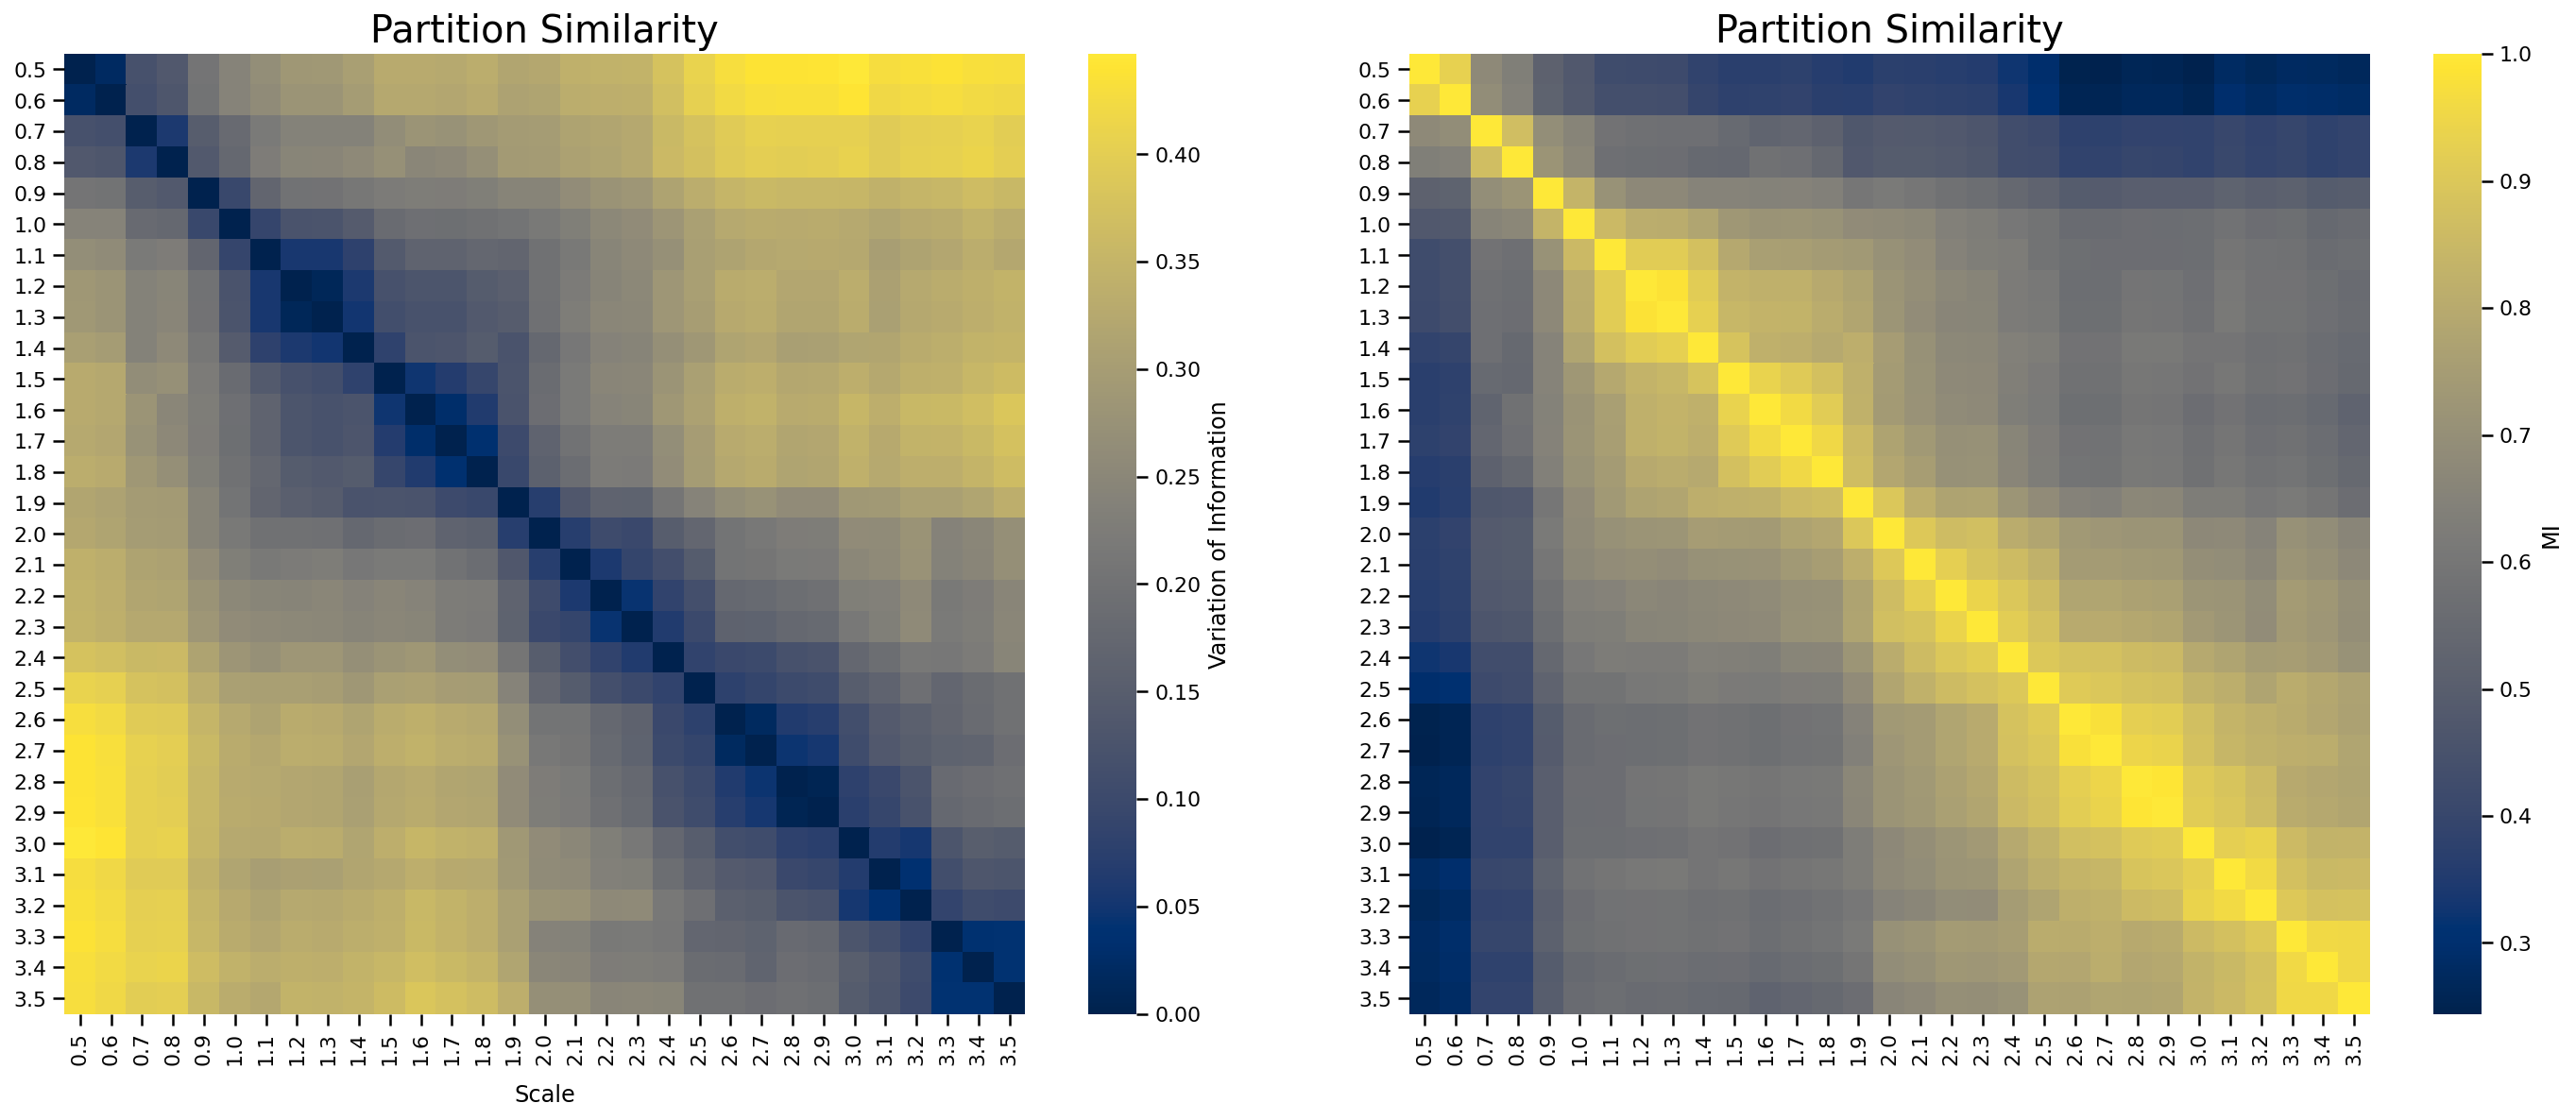

In [15]:
plot_partition_similarity(vi_mat, mi_mat)

### Plot PC Similarity

In [16]:
pc_cd, pc_sp = topological_similarity(pc_data)

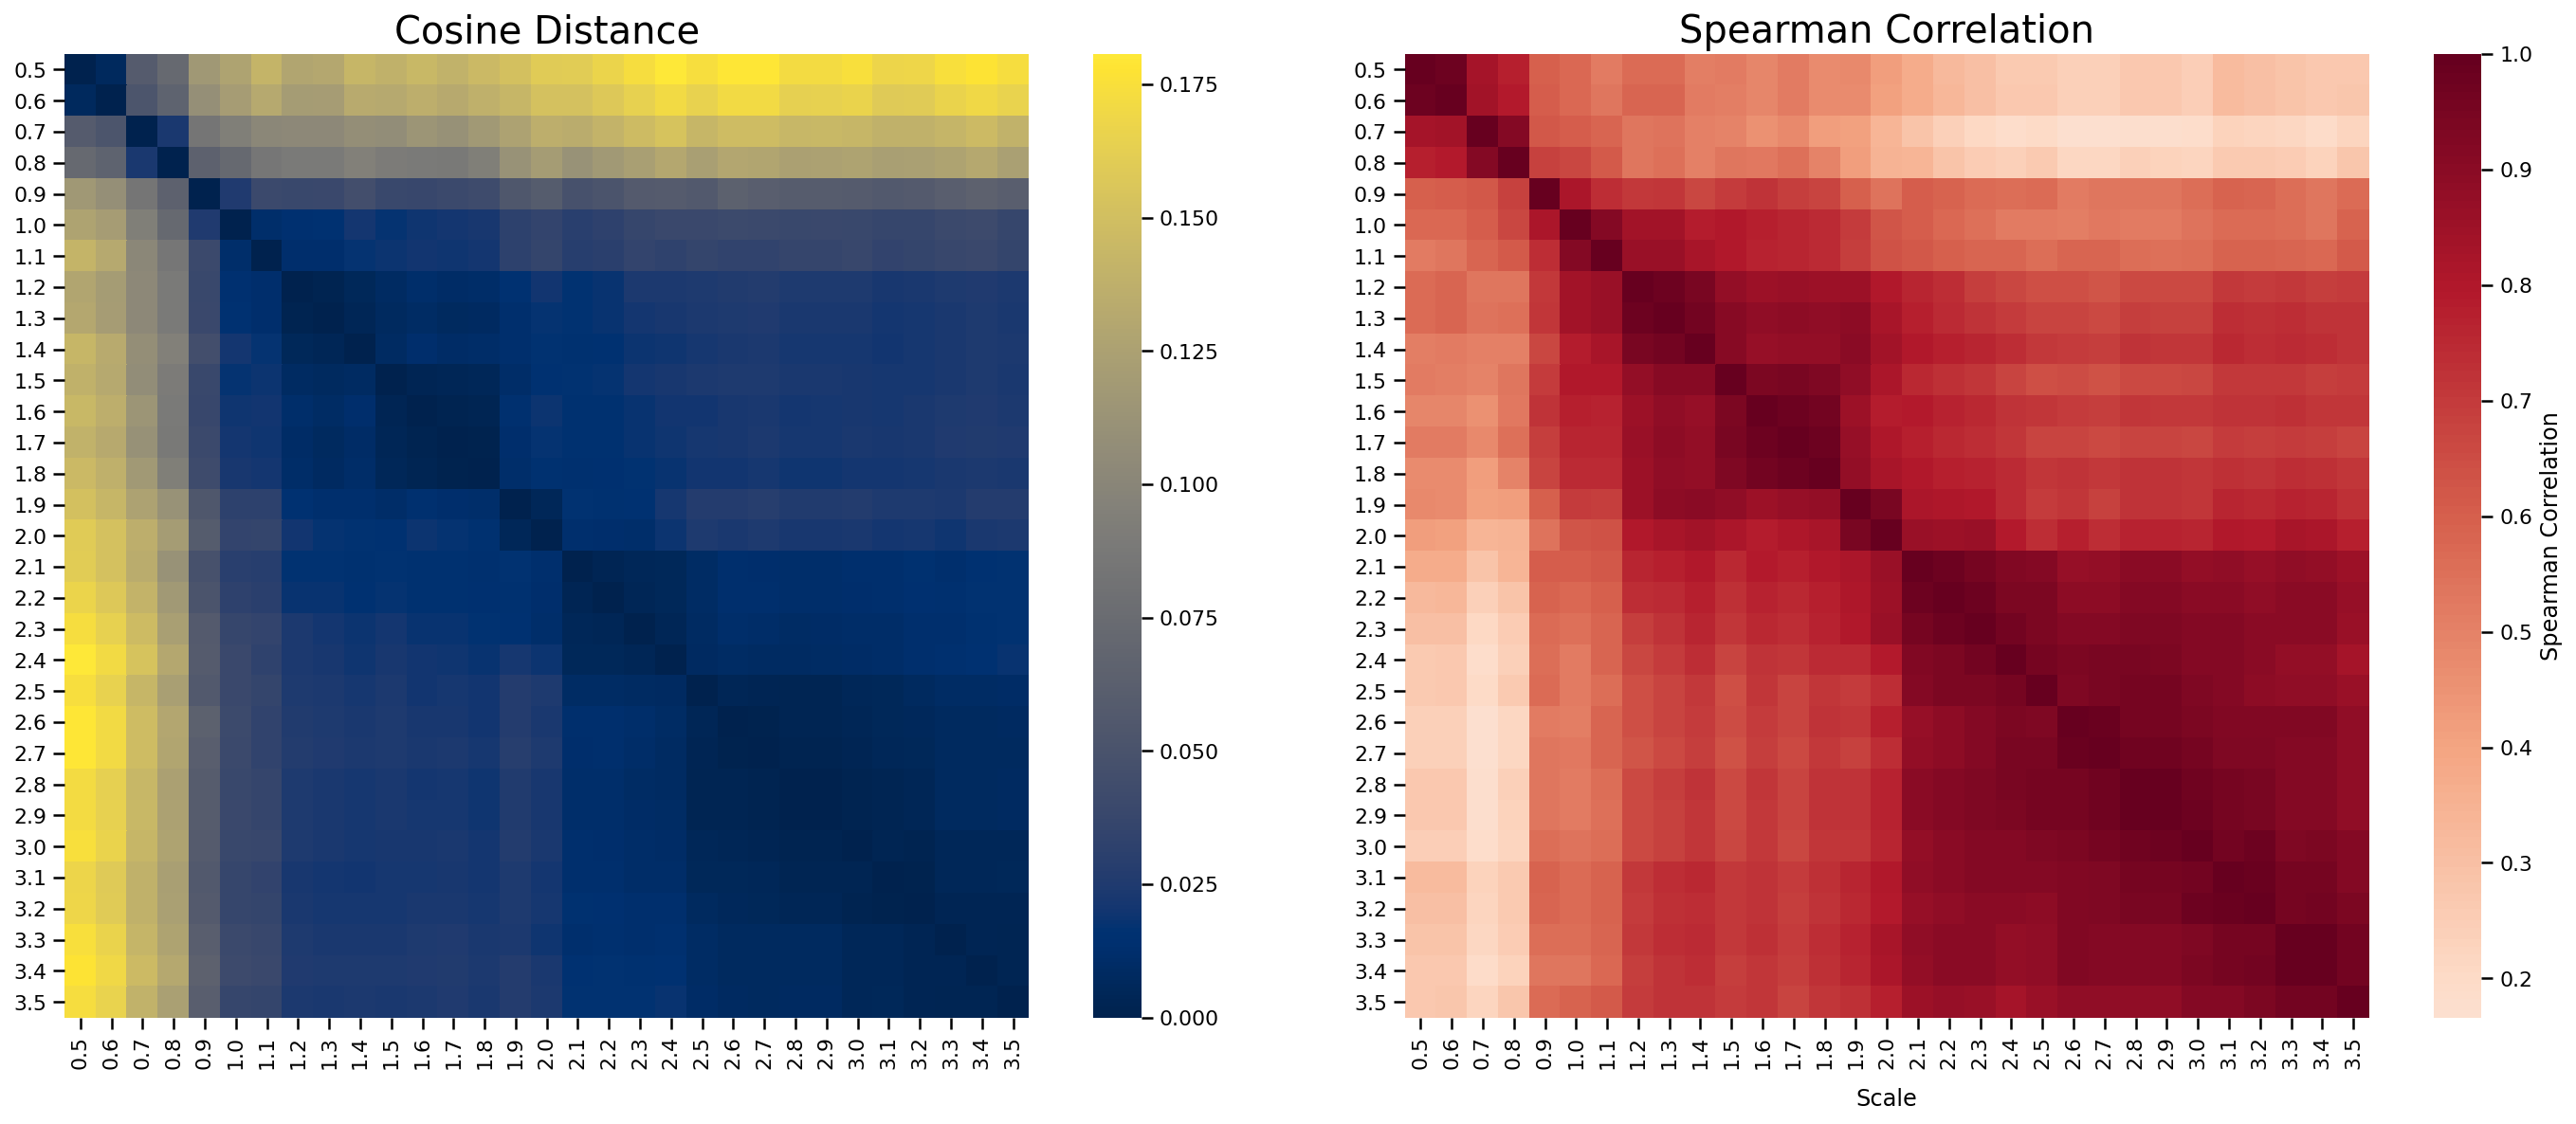

In [17]:
plot_topo_similarity(pc_cd, pc_sp)

### Plot WD Similarity

In [18]:
wd_cd, wd_sp = topological_similarity(wd_data)

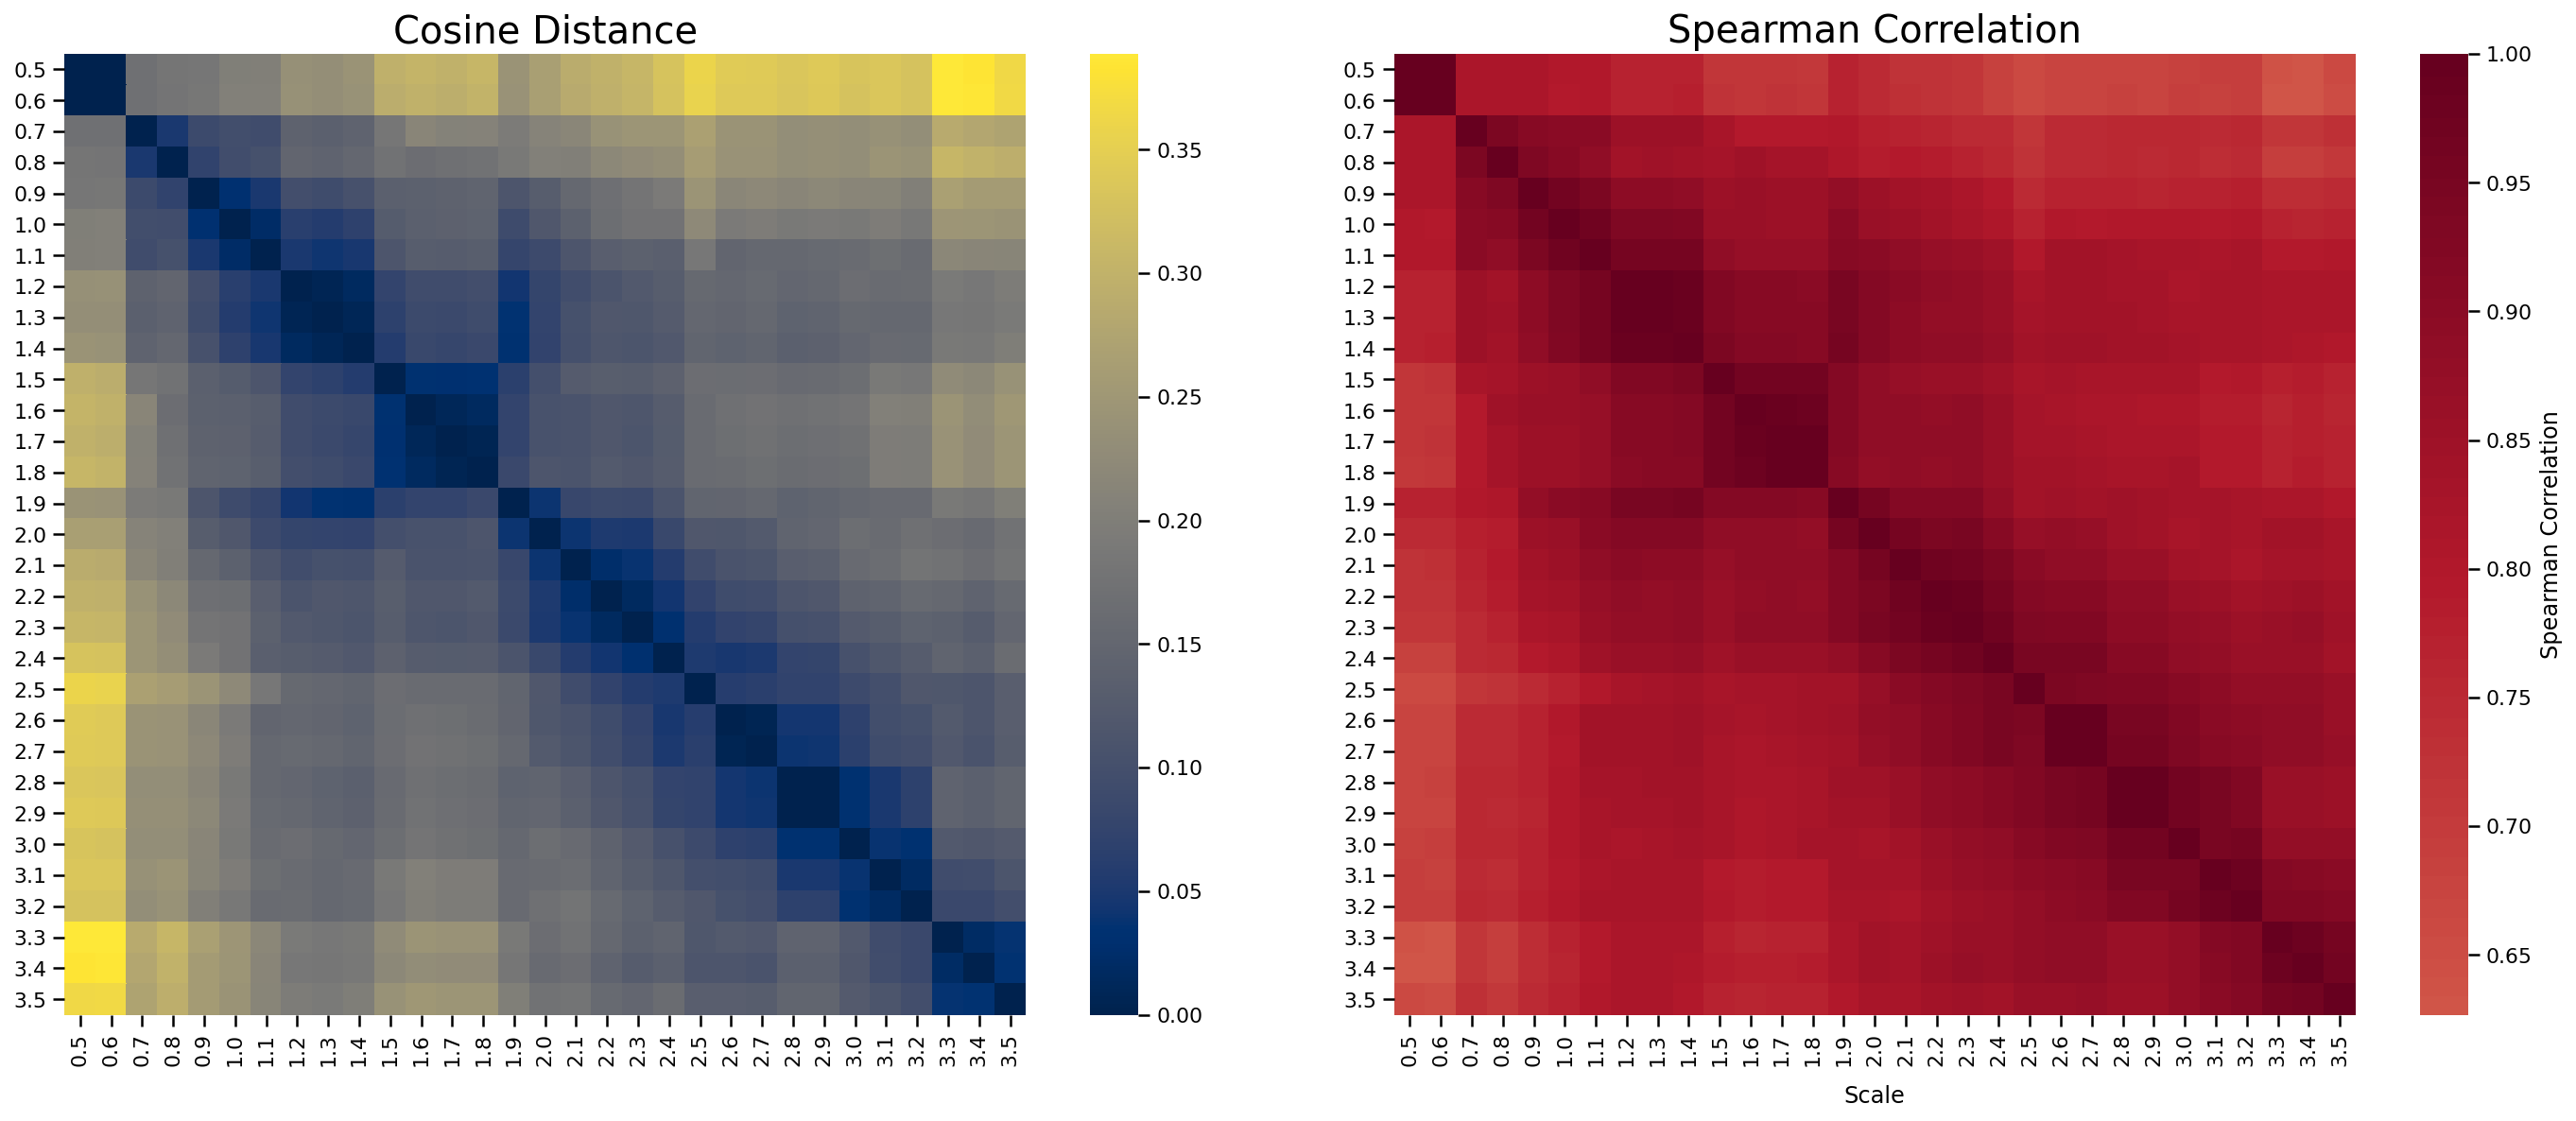

In [19]:
plot_topo_similarity(wd_cd, wd_sp)

### Plot metrics vs. resolution

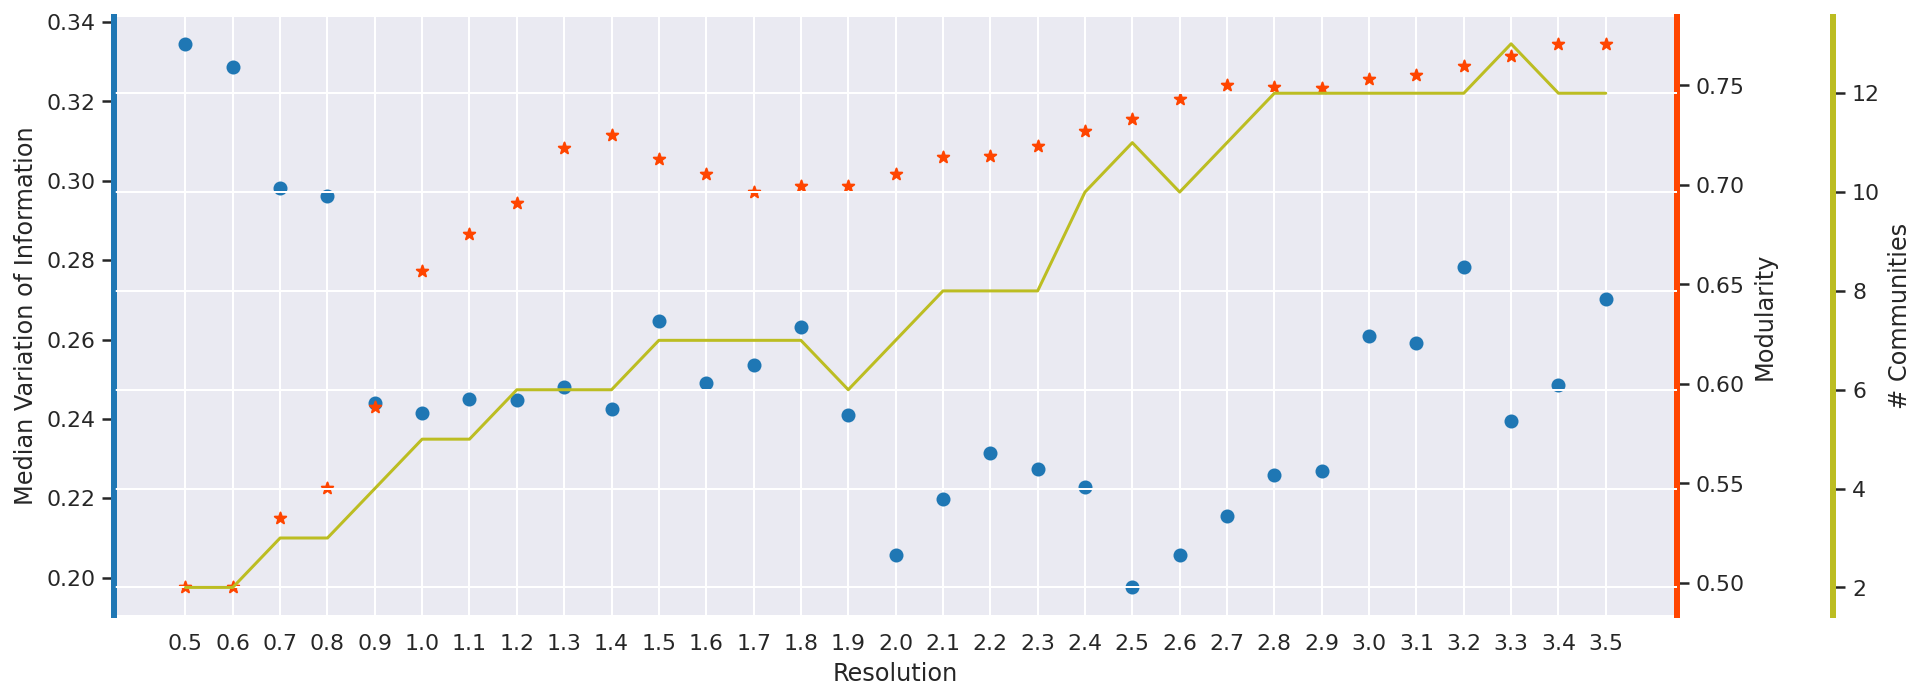

In [20]:
sns.set_style('darkgrid', {'axes.linewidth':1, 'axes.edgecolor':'black'})

fig, ax1 = plt.subplots(figsize=(14,5.5))
ax1.scatter(gamma_list, np.median(vi_mat, axis=0), label='VI', color='#1f77b4')
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax2.scatter(gamma_list, list(q_data), label='Q', color='orangered',  marker="*")
sns.lineplot(gamma_list, [sum(np.unique(i, return_counts=True)[1] > 1) for i in part_data], ax=ax3, color='tab:olive')
ax1.set_xlabel('Resolution')
ax1.set_ylabel('Median Variation of Information')
ax2.set_ylabel('Modularity')
ax3.set_ylabel('# Communities')
ax1.spines['left'].set_color('#1f77b4')
ax2.spines['left'].set_color('#1f77b4')
ax3.spines['left'].set_color('#1f77b4')
ax2.spines['right'].set_color('orangered')
ax3.spines['right'].set_color('tab:olive')
ax2.spines['right'].set_linewidth(3)
ax2.spines['left'].set_linewidth(3)
ax3.spines['right'].set_linewidth(3)
ax1.xaxis.grid(True)
ax2.yaxis.grid(False)
ax1.yaxis.grid(False)
#fig.legend(loc='center right', bbox_to_anchor=(0.9,0.5))
ax3.spines["right"].set_position(("axes", 1.1))
sns.despine(top=True, bottom=True, right=False)

#plt.tight_layout()

In [21]:
vi_sum = np.sum(vi_mat, axis=0)
mi_sum = np.sum(mi_mat, axis=0)

In [22]:
vi_median = np.median(vi_mat, axis=0)
mi_median = np.median(mi_mat, axis=0)

In [23]:
print(f'Max MI Median: {gamma_list[np.argmax(mi_median)]}')
print(f'Min VI Median: {gamma_list[np.argmin(vi_median)]}')
print(f'Max MI Sum: {gamma_list[np.argmax(mi_sum)]}')
print(f'Min VI Sum: {gamma_list[np.argmin(vi_sum)]}')

Max MI Median: 2.5
Min VI Median: 2.5
Max MI Sum: 2.0
Min VI Sum: 2.0


### Visualize Maximally Representitive Parition

In [18]:
def prepare_communities_NCT(membership_list):
    n_communities = len(np.unique(membership_list))
    color_pallette = sns.color_palette("tab20", n_communities).as_hex()
    module_colors = np.empty(246, dtype='object')
    for mod_id in range(1, n_communities+1):
        module_colors[membership_list == mod_id] = color_pallette[mod_id-1]
    return module_colors, color_pallette

In [19]:
def plot_connectograph(corr_mat, module_colors, cmap='RdBu_r', vmin=-1, vmax=1, center=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    ms = sns.heatmap(corr_mat, xticklabels=False, yticklabels=False,
               vmax=vmax, vmin=vmin, cmap=cmap, ax=ax1, center=center)
    #plt.colorbar(ms, ax=ax1)
    plotting.plot_connectome(corr_mat, coord_list, node_size=50, edge_cmap='RdBu_r',
                             node_color=list(module_colors), edge_threshold='99.999%', axes=ax2)

### Gamma = 2.0

In [20]:
sns.set_style('ticks')

In [21]:
coord_list = np.loadtxt('/home/despoB/DistractWM/AllDistract/data/meta/bna_coords.txt')

In [22]:
node_memberships_func = np.loadtxt('/home/despo/dlurie/Projects/timescale_hierarchy/results/structural_connectivity/Yeh-HCP842_BNA_log_count_mat_Louvain/gamma_2.0_GraphPartition.txt')

In [23]:
colors_func, pallette_func = prepare_communities_NCT(node_memberships_func)

In [12]:
reordered_mat_func = np.loadtxt('/home/despo/dlurie/Projects/timescale_hierarchy/results/structural_connectivity/Yeh-HCP842_BNA_log_count_mat_Louvain/gamma_2.0_ReorderedMatrix.txt').reshape(246,246)

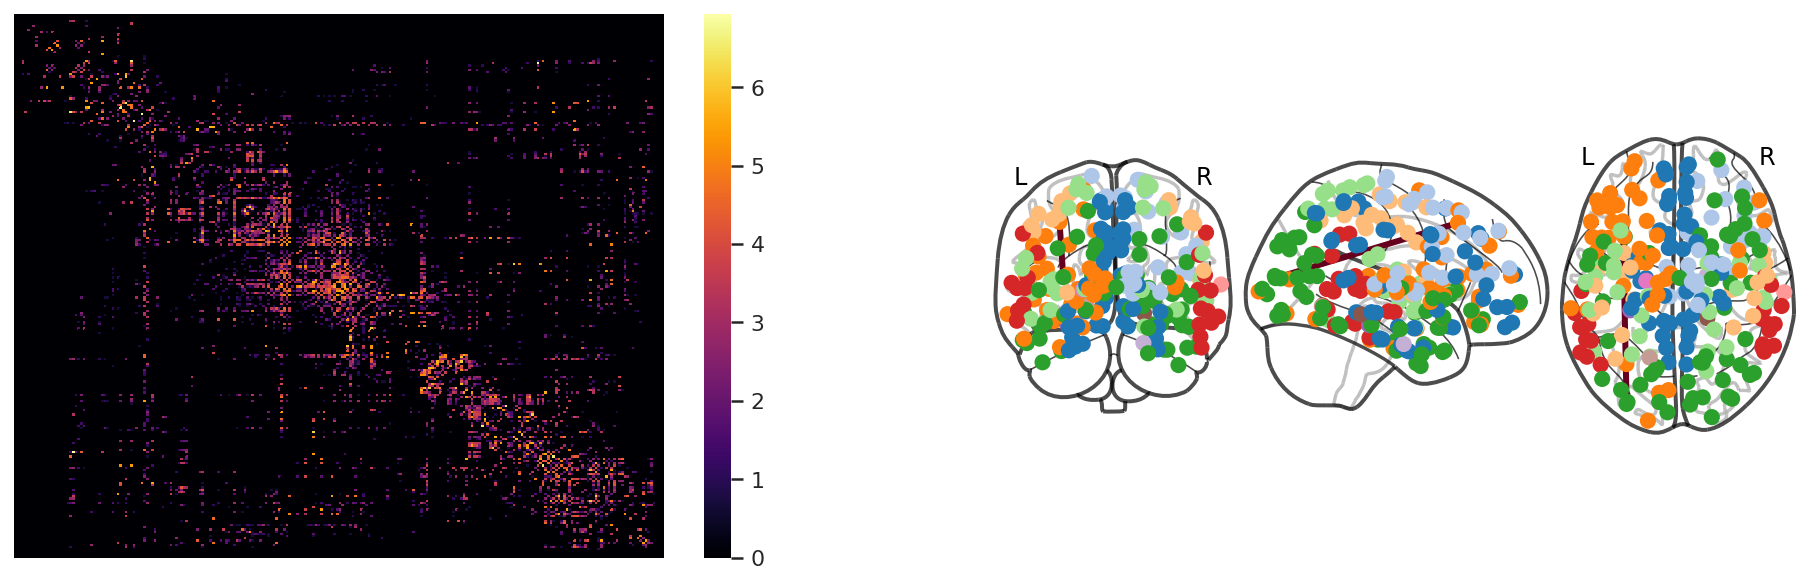

In [25]:
plot_connectograph(reordered_mat_func, colors_func, vmin=0, vmax=None, cmap='inferno')

In [26]:
len(np.unique(node_memberships_func))

13

In [27]:
np.unique(node_memberships_func, return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 array([48, 29, 42, 18, 54, 28, 21,  1,  1,  1,  1,  1,  1]))

Six communities include only a single region. We will set these all to the same value and consider them as unassigned.

In [28]:
node_memberships_func_fix = node_memberships_func.copy()

In [29]:
node_memberships_func_fix[node_memberships_func_fix > 7] = 8

In [30]:
np.unique(node_memberships_func_fix)

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [31]:
from matplotlib.colors import ListedColormap

In [32]:
c10 = sns.palettes.color_palette(palette="colorblind", n_colors=10)

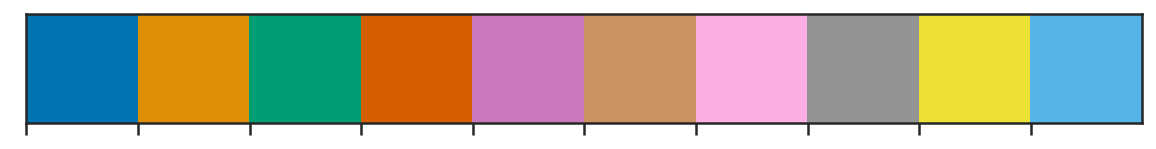

In [33]:
sns.palplot(c10)

In [34]:
sevenup = c10[7:]

In [35]:
sevenup.reverse()

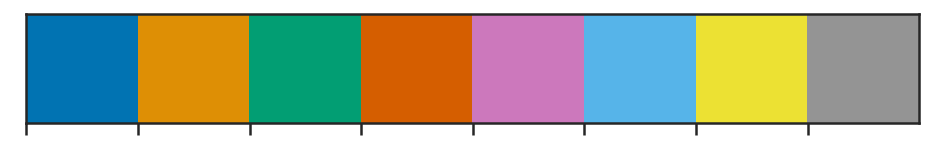

In [36]:
sns.palplot(c10[0:5]+sevenup)

In [37]:
len(c10[0:5]+sevenup)

8

In [38]:
c8 = ListedColormap(c10[0:5]+sevenup, name='c8')

In [39]:
BNA_4D = image.load_img('/home/despoB/dlurie/Projects/timescale_hierarchy/viz/BNA_4D.nii.gz')

In [40]:
part_img = regions.signals_to_img_maps(node_memberships_func_fix, BNA_4D)

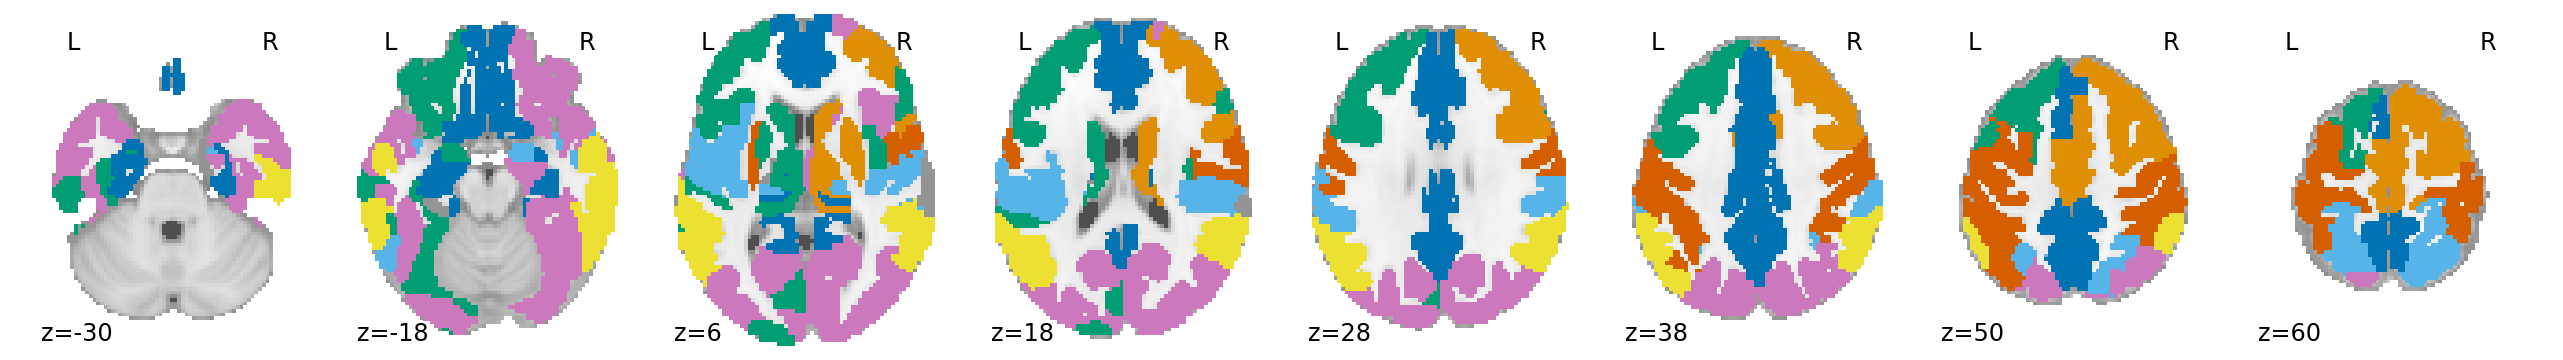

In [41]:
f = plotting.plot_roi(part_img, display_mode='z', cut_coords=[-30, -18, 6, 18, 28, 38, 50, 60],cmap=c8, vmin=1, threshold=0.1, alpha=1, colorbar=False)

In [43]:
atlas_lh = surface.load_surf_data('/home/despoB/dlurie/Data/reference/Brainnetome/BNA/BN_Atlas_freesurfer/fsaverage/label/lh.BN_Atlas.annot')
atlas_rh = surface.load_surf_data('/home/despoB/dlurie/Data/reference/Brainnetome/BNA/BN_Atlas_freesurfer/fsaverage/label/rh.BN_Atlas.annot')

In [44]:
lh_pial = surface.load_surf_mesh('/home/despoB/dlurie/Data/reference/Brainnetome/BNA/BN_Atlas_freesurfer/fsaverage/surf/lh.pial')
rh_pial = surface.load_surf_mesh('/home/despoB/dlurie/Data/reference/Brainnetome/BNA/BN_Atlas_freesurfer/fsaverage/surf/rh.pial')
lh_infl = surface.load_surf_mesh('/home/despoB/dlurie/Data/reference/Brainnetome/BNA/BN_Atlas_freesurfer/fsaverage/surf/lh.inflated')
rh_infl = surface.load_surf_mesh('/home/despoB/dlurie/Data/reference/Brainnetome/BNA/BN_Atlas_freesurfer/fsaverage/surf/rh.inflated')

In [45]:
lh_curv = surface.load_surf_data('/home/despoB/dlurie/Data/CBIG/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/FreeSurfer5.3/fsaverage/surf/lh.curv')
rh_curv = surface.load_surf_data('/home/despoB/dlurie/Data/CBIG/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/FreeSurfer5.3/fsaverage/surf/rh.curv')

In [46]:
lh_sulc = surface.load_surf_data('/home/despoB/dlurie/Data/CBIG/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/FreeSurfer5.3/fsaverage/surf/lh.sulc')
rh_sulc = surface.load_surf_data('/home/despoB/dlurie/Data/CBIG/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/FreeSurfer5.3/fsaverage/surf/rh.sulc')

In [47]:
u_lh, idx_lh = np.unique(atlas_lh, return_inverse=True)
u_rh, idx_rh = np.unique(atlas_rh, return_inverse=True)

In [48]:
part_map_lh, part_map_rh = gen_surfaces(node_memberships_func_fix, idx_lh, idx_rh)

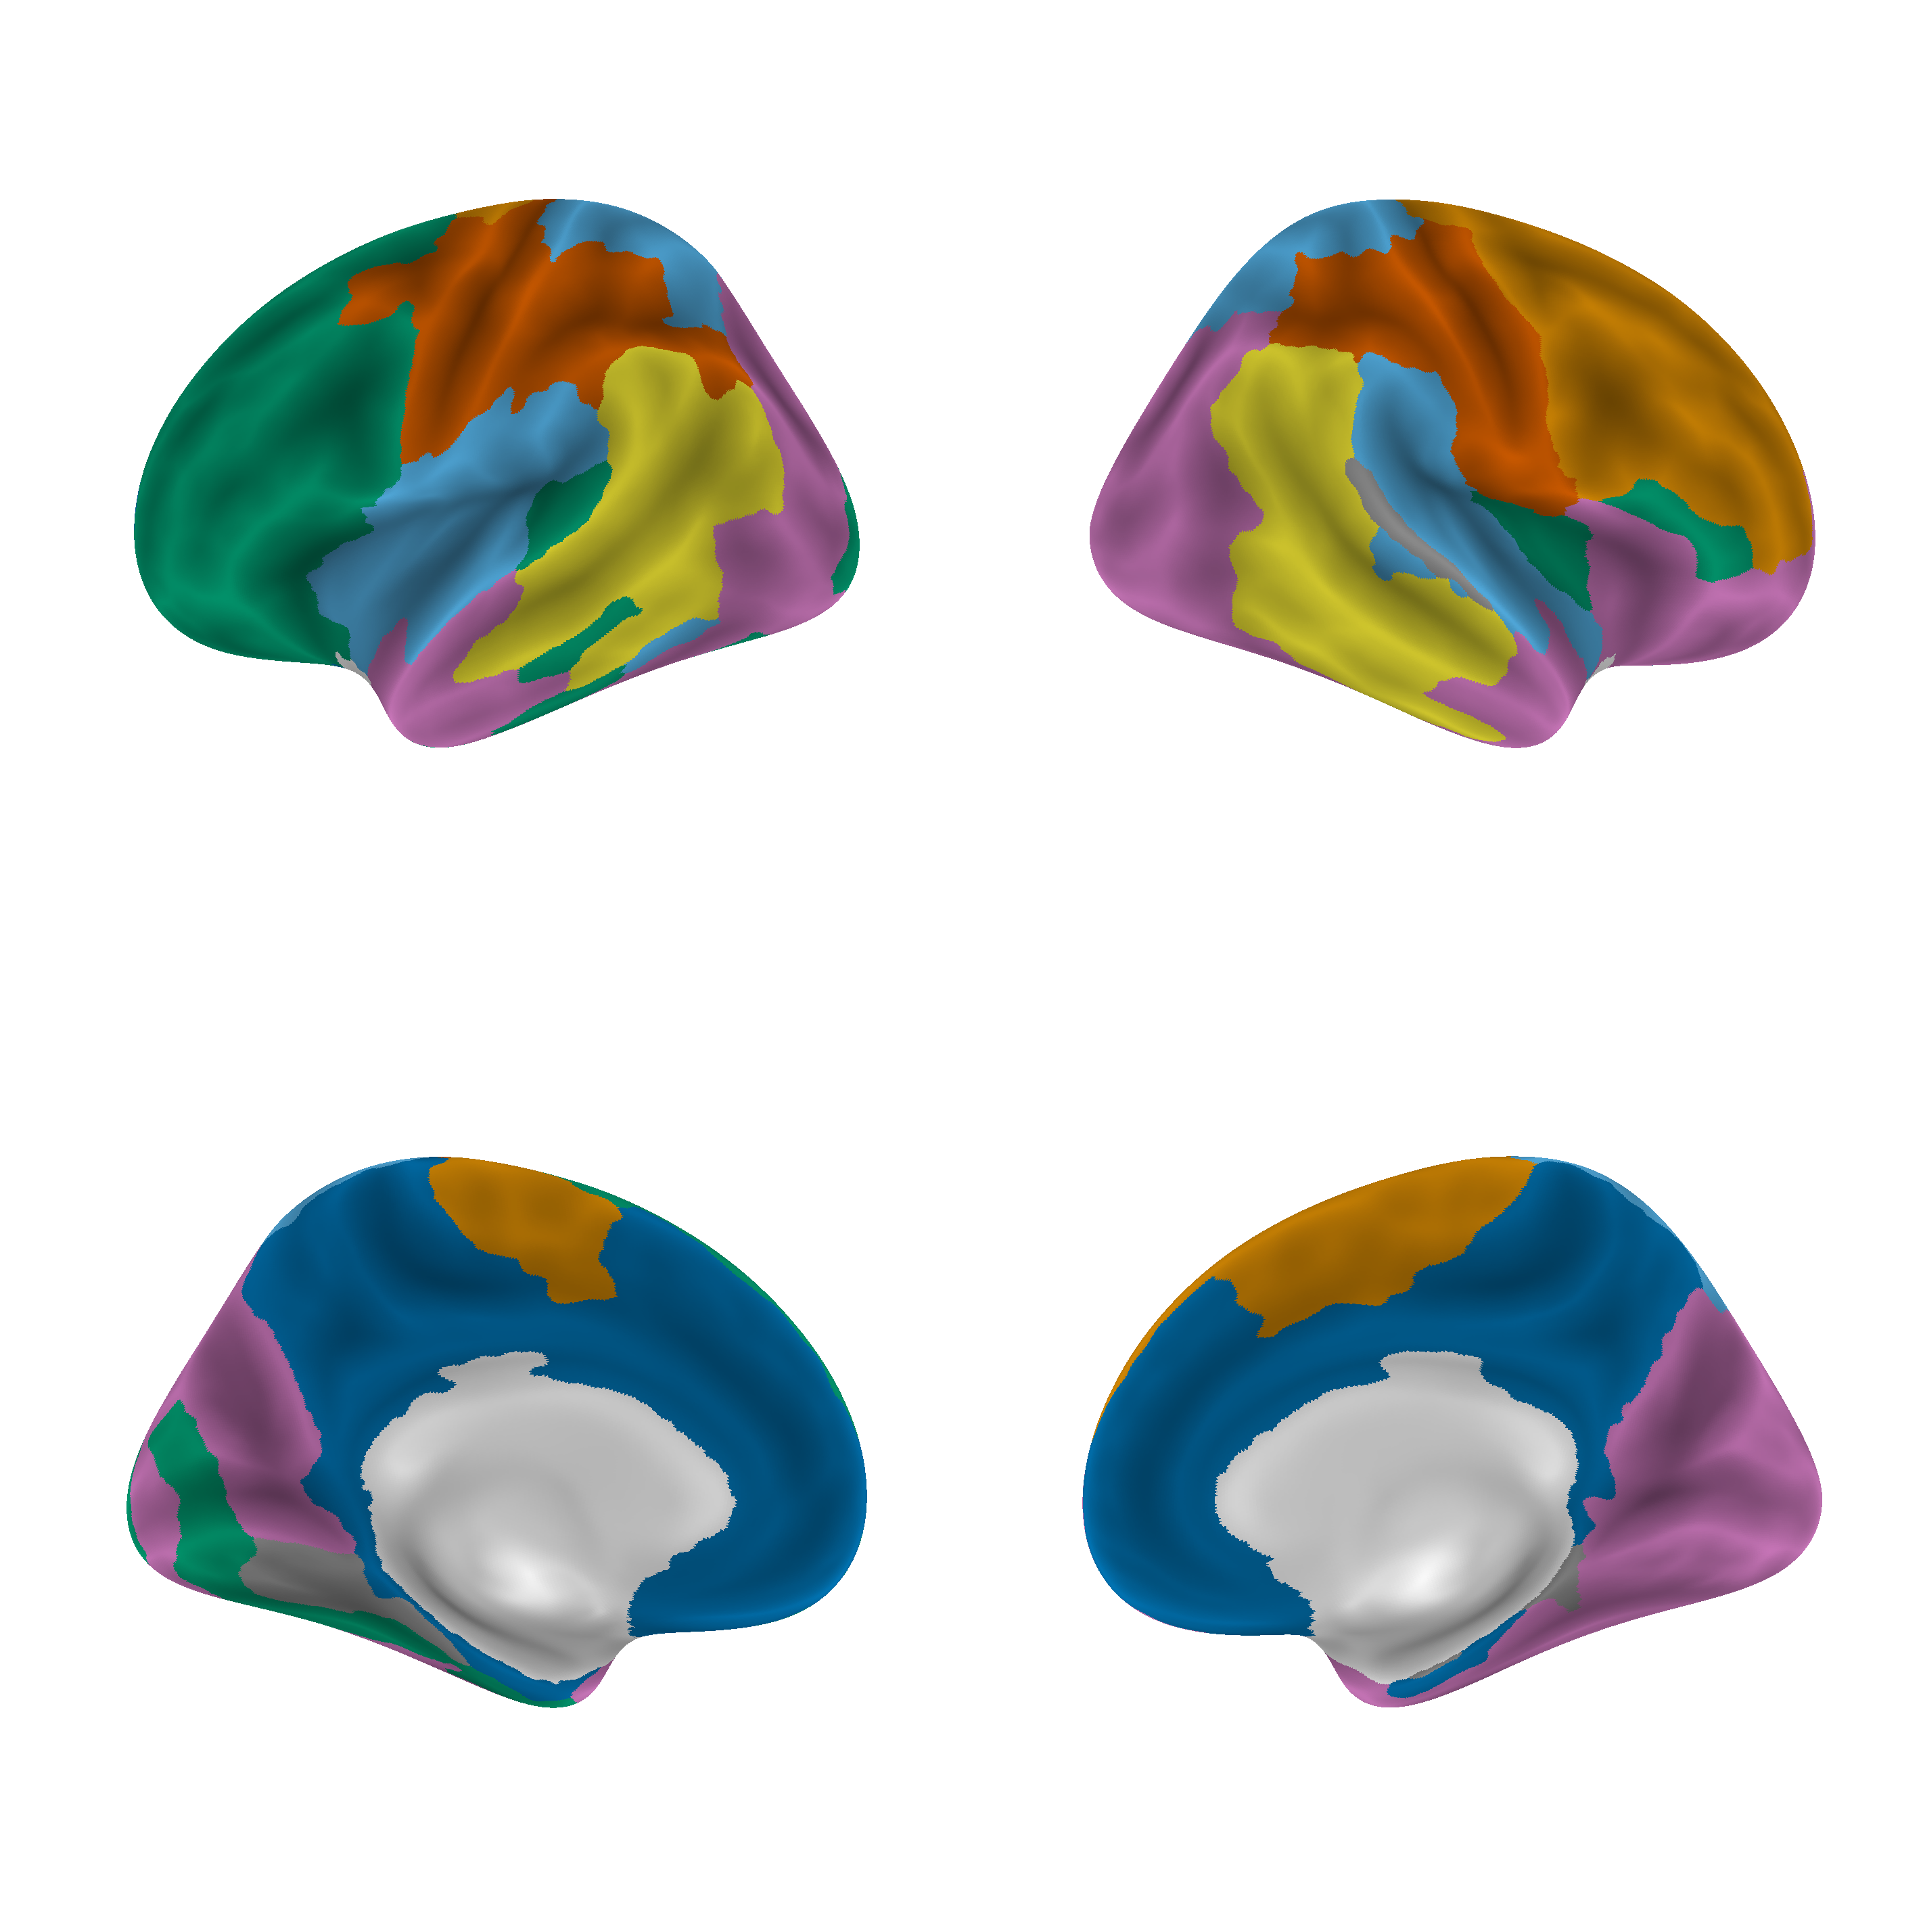

In [49]:
plot_surfaces(lh_infl, part_map_lh, lh_sulc, rh_infl, part_map_rh, rh_sulc, c8, np.min(node_memberships_func_fix), np.max(node_memberships_func_fix))